# multi-task alternate training strategy--clearence prediction

In [1]:
from molmap import model as molmodel
import molmap

import matplotlib.pyplot as plt

import pandas as pd
from tqdm import tqdm
from joblib import load, dump
tqdm.pandas(ascii=True)
import numpy as np

import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
np.random.seed(12345)
tf.compat.v1.set_random_seed(12345)

RDKit WARNING: [21:30:05] Enabling RDKit 2019.09.2 jupyter extensions
/home/shenwanxiang/anaconda3/envs/deepchem23/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/shenwanxiang/anaconda3/envs/deepchem23/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/shenwanxiang/anaconda3/envs/deepchem23/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type

In [2]:
df = pd.read_csv('./Dataset_chembl_clearcaco.txt',sep=';')
task_name = 'chembl_clearcaco'

# featurizer

In [3]:
tmp_feature_dir = './tmpignore'
if not os.path.exists(tmp_feature_dir):
    os.makedirs(tmp_feature_dir)
    
mp1 = molmap.loadmap('../descriptor.mp')
mp2 = molmap.loadmap('../fingerprint.mp')

X1_name = os.path.join(tmp_feature_dir, 'X1_%s.data' % task_name)
X2_name = os.path.join(tmp_feature_dir, 'X2_%s.data' % task_name)
if not os.path.exists(X1_name):
    X1 = mp1.batch_transform(X_smiles, n_jobs = 8)
    dump(X1, X1_name)
else:
    X1 = load(X1_name)
    
if not os.path.exists(X2_name): 
    X2 = mp2.batch_transform(X_smiles, n_jobs = 8)
    dump(X2, X2_name)
else:
    X2 = load(X2_name)

In [4]:
def get_idx_and_Y(df, task, split):
    train_idx = df[df[split] == 'Train'].index
    valid_idx = df[df[split] == 'Test'].index ##according to the paper<page 1256, Data Preparation>, they use this for early stopping
    test_idx = df[df[split] == 'Ext'].index #their Ext set is our final test set
    def _apply_float(x):
        if type(x) == float:
            return x
        else:
            x = x.replace(',','.')
            return float(x)
    Y = df[task].apply(_apply_float).to_frame().values
    Y = np.log10(Y + 1e-8)
    print(len(train_idx), len(valid_idx), len(test_idx))
    return (train_idx, valid_idx, test_idx), Y

In [5]:
df.columns

Index(['ID', 'Canonical_Smiles', 'hlm_clearance[mL.min-1.g-1]',
       'rlm_clearance[mL.min-1.g-1]', 'mlm_clearance[mL.min-1.g-1]',
       'caco2_PAPP[10^-7cm/s]', 'Set_hlm', 'Set_rlm', 'Set_mlm', 'Set_caco'],
      dtype='object')

In [6]:
t = ['hlm_clearance[mL.min-1.g-1]','rlm_clearance[mL.min-1.g-1]', 'mlm_clearance[mL.min-1.g-1]']
m = ['Set_hlm', 'Set_rlm', 'Set_mlm']


task_epochs = 500
alternate_epochs = 1
alternate_rounds = 40
patience = 10


batch_size=128
lr = 0.0001

dense_layers=[256, 128, 32]
dense_avf='relu'
last_avf = 'linear'

In [7]:
from sklearn.utils import shuffle
basemodel_data = []
for i, j in zip(t, m):
    (train_idx, valid_idx, test_idx), Y = get_idx_and_Y(df, i, j)
    trainY = Y[train_idx]
    trainX = (X1[train_idx], X2[train_idx])
    basemodel_data.append([trainX, trainY])

4020 801 527
1636 331 199
617 117 56


## alternate strategy to train a base model

In [8]:
model = None
for i in tqdm(range(alternate_rounds)):
    basemodel_data = shuffle(basemodel_data) #shffule
    for trainX,trainY in basemodel_data:
        if model == None:
            molmap1_size = X1.shape[1:]
            molmap2_size = X2.shape[1:]
            model = molmodel.net.DoublePathNet(molmap1_size, molmap2_size, 
                                               n_outputs = trainY.shape[1],
                                               dense_layers = dense_layers,
                                               dense_avf = dense_avf, last_avf = last_avf)
            opt = tf.keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #
            model.compile(optimizer = opt, loss = 'mse')
        model.fit(trainX, trainY, batch_size=batch_size, epochs=alternate_epochs, verbose= 0, shuffle = True) #
        
model.save('./basemodel.h5')

  0%|          | 0/40 [00:00<?, ?it/s]

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


100%|██████████| 40/40 [01:01<00:00,  1.41s/it]


## 01.branch training for task of hlm

In [9]:
task = 'hlm_clearance[mL.min-1.g-1]'
split = 'Set_hlm'

(train_idx, valid_idx, test_idx), Y = get_idx_and_Y(df, task, split)

trainY = Y[train_idx]
validY = Y[valid_idx]
testY = Y[test_idx]

trainX = (X1[train_idx], X2[train_idx])
validX = (X1[valid_idx], X2[valid_idx])
testX  = (X1[test_idx], X2[test_idx])


4020 801 527


In [10]:
performance = molmodel.cbks.Reg_EarlyStoppingAndPerformance((trainX, trainY), 
                                                               (validX, validY),
                                                               MASK=1e8,
                                                               patience = patience, 
                                                               criteria = 'val_loss',
                                                              )

opt = tf.keras.optimizers.Adam(lr = lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #
model.load_weights('./basemodel.h5')
model.fit(trainX, trainY, batch_size=batch_size, 
      epochs=task_epochs, verbose= 0, shuffle = True, 
      validation_data = (validX, validY), 
      callbacks=[performance]) #

epoch: 0001, loss: 0.0440 - val_loss: 0.1730; rmse: 0.1936 - rmse_val: 0.4159;  r2: 0.9187 - r2_val: 0.6160                                                                                                    
epoch: 0002, loss: 0.0408 - val_loss: 0.1776; rmse: 0.2092 - rmse_val: 0.4214;  r2: 0.9272 - r2_val: 0.6172                                                                                                    
epoch: 0003, loss: 0.0375 - val_loss: 0.1727; rmse: 0.1911 - rmse_val: 0.4156;  r2: 0.9327 - r2_val: 0.6195                                                                                                    
epoch: 0004, loss: 0.0332 - val_loss: 0.1699; rmse: 0.1729 - rmse_val: 0.4122;  r2: 0.9386 - r2_val: 0.6189                                                                                                    
epoch: 0005, loss: 0.0309 - val_loss: 0.1725; rmse: 0.1768 - rmse_val: 0.4153;  r2: 0.9432 - r2_val: 0.6196                                                             

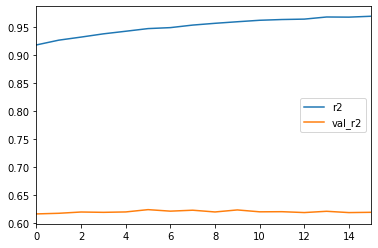

In [11]:
dfp = pd.DataFrame(performance.history)[['r2', 'val_r2']]
dfp.plot()

In [12]:
performance.evaluate(trainX, trainY) # RMSE, R^2

([0.15650891531946762], [0.9479566979884002])

In [13]:
performance.evaluate(validX, validY) # RMSE, R^2

([0.4084460299405322], [0.6237163850121752])

In [14]:
performance.evaluate(testX, testY) # RMSE, R^2

([0.42705363069542096], [0.5797107759029823])

## 02.branch training for task of rlm

In [15]:
task = 'rlm_clearance[mL.min-1.g-1]'
split = 'Set_rlm'

(train_idx, valid_idx, test_idx), Y = get_idx_and_Y(df, task, split)

trainY = Y[train_idx]
validY = Y[valid_idx]
testY = Y[test_idx]

trainX = (X1[train_idx], X2[train_idx])
validX = (X1[valid_idx], X2[valid_idx])
testX  = (X1[test_idx], X2[test_idx])

1636 331 199


In [16]:
performance = molmodel.cbks.Reg_EarlyStoppingAndPerformance((trainX, trainY), 
                                                               (validX, validY),
                                                               MASK=1e8,
                                                               patience = patience, 
                                                               criteria = 'val_loss',
                                                              )

opt = tf.keras.optimizers.Adam(lr = lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #
model.load_weights('./basemodel.h5')
model.fit(trainX, trainY, batch_size=batch_size, 
      epochs=task_epochs, verbose= 0, shuffle = True, 
      validation_data = (validX, validY), 
      callbacks=[performance]) #


epoch: 0001, loss: 0.0783 - val_loss: 0.1862; rmse: 0.2411 - rmse_val: 0.4316;  r2: 0.9228 - r2_val: 0.7116                                                                                                    
epoch: 0002, loss: 0.0513 - val_loss: 0.1722; rmse: 0.2010 - rmse_val: 0.4150;  r2: 0.9372 - r2_val: 0.7327                                                                                                    
epoch: 0003, loss: 0.0436 - val_loss: 0.1764; rmse: 0.2108 - rmse_val: 0.4199;  r2: 0.9468 - r2_val: 0.7299                                                                                                    
epoch: 0004, loss: 0.0367 - val_loss: 0.1673; rmse: 0.1688 - rmse_val: 0.4090;  r2: 0.9544 - r2_val: 0.7362                                                                                                    
epoch: 0005, loss: 0.0304 - val_loss: 0.1686; rmse: 0.1634 - rmse_val: 0.4106;  r2: 0.9591 - r2_val: 0.7393                                                             

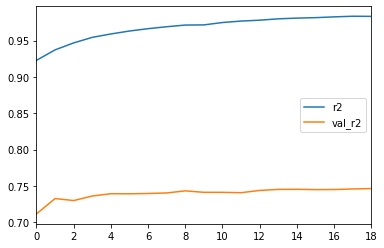

In [17]:
dfp = pd.DataFrame(performance.history)[['r2', 'val_r2']]
dfp.plot()

In [18]:
performance.evaluate(trainX, trainY) # RMSE, R^2

([0.13983376508704334], [0.9713406014885144])

In [19]:
performance.evaluate(validX, validY) # RMSE, R^2

([0.4027403467623635], [0.7432707657720055])

In [20]:
performance.evaluate(testX, testY) # RMSE, R^2

([0.3506525369176651], [0.7892490109157458])

## 03.branch training for task of mlm

In [21]:
task = 'mlm_clearance[mL.min-1.g-1]'
split = 'Set_mlm'


(train_idx, valid_idx, test_idx), Y = get_idx_and_Y(df, task, split)

trainY = Y[train_idx]
validY = Y[valid_idx]
testY = Y[test_idx]

trainX = (X1[train_idx], X2[train_idx])
validX = (X1[valid_idx], X2[valid_idx])
testX  = (X1[test_idx], X2[test_idx])


617 117 56


In [22]:
performance = molmodel.cbks.Reg_EarlyStoppingAndPerformance((trainX, trainY), 
                                                               (validX, validY),
                                                               MASK=1e8,
                                                               patience = patience, 
                                                               criteria = 'val_loss',
                                                              )

opt = tf.keras.optimizers.Adam(lr = lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #
model.load_weights('./basemodel.h5')
model.fit(trainX, trainY, batch_size=batch_size, 
      epochs=task_epochs, verbose= 0, shuffle = True, 
      validation_data = (validX, validY), 
      callbacks=[performance]) #

epoch: 0001, loss: 0.1066 - val_loss: 0.2664; rmse: 0.3416 - rmse_val: 0.5161;  r2: 0.8996 - r2_val: 0.6414                                                                                                    
epoch: 0002, loss: 0.0864 - val_loss: 0.2185; rmse: 0.2552 - rmse_val: 0.4675;  r2: 0.9126 - r2_val: 0.6366                                                                                                    
epoch: 0003, loss: 0.0576 - val_loss: 0.2231; rmse: 0.2330 - rmse_val: 0.4723;  r2: 0.9245 - r2_val: 0.6191                                                                                                    
epoch: 0004, loss: 0.0514 - val_loss: 0.2260; rmse: 0.2183 - rmse_val: 0.4755;  r2: 0.9353 - r2_val: 0.6138                                                                                                    
epoch: 0005, loss: 0.0453 - val_loss: 0.2063; rmse: 0.1858 - rmse_val: 0.4542;  r2: 0.9441 - r2_val: 0.6247                                                             

In [23]:
performance.evaluate(trainX, trainY) # RMSE, R^2

([0.17017886005393867], [0.9548359921669104])

In [24]:
performance.evaluate(validX, validY) # RMSE, R^2

([0.4421960985447453], [0.6335996177110838])

In [25]:
performance.evaluate(testX, testY) # RMSE, R^2

([0.4908624713106153], [0.5260398861641483])

In [26]:
model.count_params()

803681